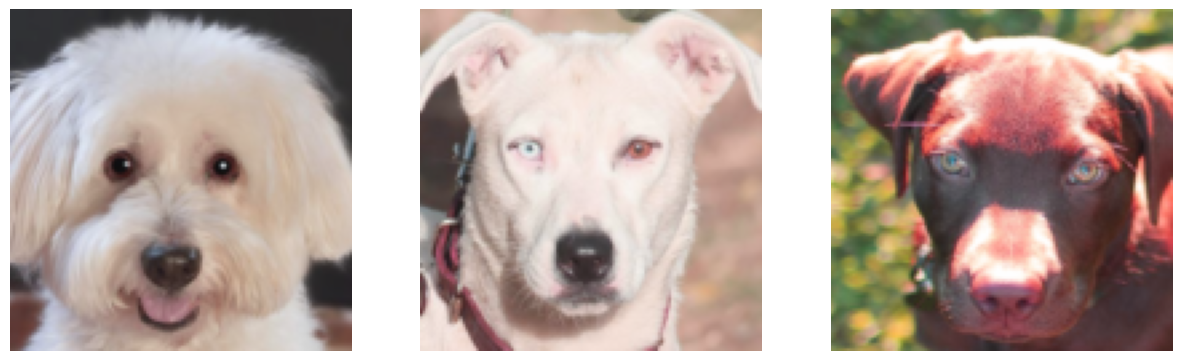

In [2]:
from src.dataset import AFHQDataset
import matplotlib.pyplot as plt
import torch

dataset = AFHQDataset(split='dog', train=True, img_size=128, augment=True)
imgs = [dataset[i] for i in range(3)]
imgs = torch.stack(imgs)
imgs = imgs.permute(0, 2, 3, 1)
imgs = (imgs + 1) / 2
imgs = imgs.numpy()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
plt.show()


In [3]:
from src.dataset import CelebADataset

dataset = CelebADataset(attr=20, on_or_off=1, img_size=128, augment=True)
imgs = [dataset[i] for i in range(3)]
imgs = torch.stack(imgs)
imgs = imgs.permute(0, 2, 3, 1)
imgs = (imgs + 1) / 2
imgs = imgs.numpy()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
plt.show()

Files already downloaded and verified


KeyboardInterrupt: 

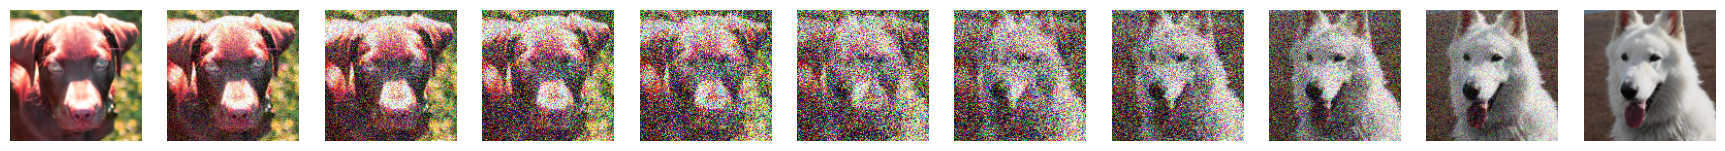

In [ ]:
from src.dataset import AFHQDataset
import matplotlib.pyplot as plt
from src.lightning_modules.schedulers import DSBScheduler

scheduler = DSBScheduler(10, 0.1, 'terminal')
dataset = AFHQDataset(split='dog', train=True, img_size=128, augment=True)
img0 = dataset[2]
img1 = dataset[3]

trajectory = scheduler.deterministic_sample(img0, img1, return_trajectory=True, training=False)
len_traj = len(trajectory)
fig, axs = plt.subplots(1, len_traj, figsize=(2 * len_traj, 2))
axs : list[plt.Axes]
for i in range(len_traj):
    img = trajectory[i].permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = img.clip(0, 1)
    axs[i].imshow(img)
    axs[i].axis('off')
    
plt.show()

In [ ]:
from src.lightning_modules import FM
from src.networks import StableDiffusionXL, MediumUNet

unet = MediumUNet()
encoder = StableDiffusionXL()

fm = FM(model=unet, encoder_decoder=encoder)

Loaded VAE model stabilityai/stable-diffusion-xl-base-1.0


In [ ]:
from src.networks import SmallUNet, MediumUNet, LargeUNet

small_unet = SmallUNet()
medium_unet = MediumUNet()
large_unet = LargeUNet()

small_unet_params = sum(p.numel() for p in small_unet.parameters())
medium_unet_params = sum(p.numel() for p in medium_unet.parameters())
large_unet_params = sum(p.numel() for p in large_unet.parameters())

print(f"Small UNet: {small_unet_params}")
print(f"Medium UNet: {medium_unet_params}")
print(f"Large UNet: {large_unet_params}")

/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Small UNet: 95092228
Medium UNet: 163560068
Large UNet: 262387588


In [ ]:
import IPython.display as ipd
from src.dataset import (
    VoxCeleb, 
    EarsGender, 
    GenderAudioDataset, 
    LibriSpeech,
    AllVoxCeleb,
    EarsFSDNoisy,
    AllLibri
)
import random
from src.networks import PretrainedMimi
import torch

encoder = PretrainedMimi()
gender = 'male'

vox_dataset = VoxCeleb(gender=gender)
print("Length of VoxCeleb dataset: ", len(vox_dataset))

ears_dataset = EarsGender(gender=gender)
print("Length of Ears dataset: ", len(ears_dataset))

libri = LibriSpeech(gender)
print("Length of LibriSpeech dataset: ", len(libri))

gender_dataset = GenderAudioDataset(gender=gender)
print("Length of gender dataset: ", len(gender_dataset))

dataset_to_investigate = EarsFSDNoisy()

for _ in range(5):
    rand_idx = random.randint(0, len(vox_dataset))
    sample = dataset_to_investigate[rand_idx]
    with torch.no_grad():
        encoded = encoder.encode(sample.unsqueeze(0))
        decoded = encoder.decode(encoded)
    ipd.display(ipd.Audio(sample, rate=gender_dataset.sample_rate))
    ipd.display(ipd.Audio(decoded.squeeze(), rate=gender_dataset.sample_rate)) 

/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/transformers/models/mimi/modeling_mimi.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


Loaded Mimi model
Length of VoxCeleb dataset:  3682
Length of Ears dataset:  6450
Length of LibriSpeech dataset:  14197
Length of gender dataset:  24329


In [ ]:
from src.dataset import BaseConcatAudio, WHAM
import IPython.display as ipd
wham = WHAM('train')
wham_dataset = BaseConcatAudio([wham], 5.0, 16000)
ipd.display(ipd.Audio(wham_dataset[0], rate=16000))

In [ ]:
from src.lightning_modules.schedulers import DSBScheduler
from src.dataset import LibriWhamPaired
from src.networks import PretrainedMimi
import torch
import IPython.display as ipd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = PretrainedMimi(new_range=(-1024, 1024)).to(device)
scheduler = DSBScheduler(100, gamma_frac=1.0, target='terminal')
sr = 24000
dataset = LibriWhamPaired(sample_rate=sr)
speech, noisyspeech = dataset[0]
xk = noisyspeech.unsqueeze(0).to(device)
xk = encoder.encode(xk)
xk_end = speech.unsqueeze(0).to(device)
xk_end = encoder.encode(xk_end)

def play_encoded_audio(xk : torch.Tensor) -> None:
    audio = encoder.decode(xk).detach().cpu().squeeze().numpy()
    ipd.display(ipd.Audio(audio, rate=sr))

play_encoded_audio(xk)
for t in reversed(scheduler.timesteps):
    xk = scheduler.step(xk, t, xk_end, training=False)
    if t % 10 == 0 or t == 1:
        print(f"Step x_{t - 1} | x_{t}")
        play_encoded_audio(xk)

In [ ]:
from src.lightning_modules import DSB
from src.networks import MediumUNet, StableDiffusionXL
from src.utils import get_ckpt_path
import torch
import matplotlib.pyplot as plt
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_path = 'people_images/andreas_billede.jpg'

forward_model = MediumUNet()
backward_model = MediumUNet()
encoder = StableDiffusionXL()
ckpt_path = get_ckpt_path(experiment_id='230325104152')
dsb = DSB.load_from_checkpoint(ckpt_path, forward_model=forward_model, backward_model=backward_model, encoder_decoder=encoder)
dsb = dsb.to(device)

/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded VAE model stabilityai/stable-diffusion-xl-base-1.0


Sampling: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


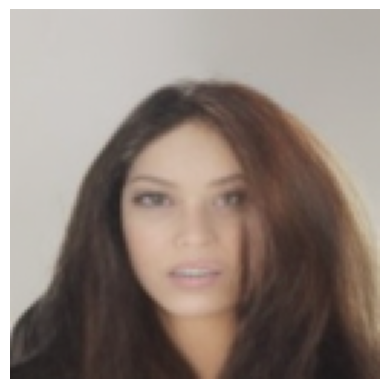

In [ ]:


from PIL import Image, ExifTags
from torch import Tensor
import numpy as np

dsb.scheduler.set_timesteps(100, 0.01, 0.01)

def load_image_with_orientation(image_path):
    image = Image.open(image_path)
    
    # Apply EXIF orientation if it exists
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = image._getexif()
        if exif is not None:
            orientation_value = exif.get(orientation, None)
            if orientation_value == 3:
                image = image.rotate(180, expand=True)
            elif orientation_value == 6:
                image = image.rotate(270, expand=True)
            elif orientation_value == 8:
                image = image.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        # If no EXIF data or orientation tag is found, do nothing
        pass
    
    return image

def image_to_tensor(image : Image.Image) -> Tensor:
    image = image.resize((128, 128))
    image = np.array(image)
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    image = image * 2 - 1
    return image

img = load_image_with_orientation(img_path)
img_tensor = image_to_tensor(img)
img_tensor = img_tensor.to(device)
with torch.no_grad():
    img_encoded = dsb.encode(img_tensor)
    img_encoded_translated = dsb.sample(img_encoded, True, False, True, 'inference')
    img_translated = dsb.decode(img_encoded_translated)
img_translated = img_translated.squeeze().cpu().permute(1, 2, 0).clip(-1, 1).numpy()
img_translated = (img_translated + 1) / 2
plt.imshow(img_translated)
plt.axis('off')
plt.show()

In [ ]:
from IPython.display import Audio
from IPython.display import display
from src.dataset import LibriWhamPaired
from src.networks import DACEncodec
from src.networks import MediumUNet1D, SmallUNet1D
import torch
device = 'cpu'

dataset = LibriWhamPaired(sample_rate=16000, length_seconds=2.56)
audio = dataset[0][0].unsqueeze(0)
audio = audio.to(device)

model = DACEncodec().to(device)
encoded = model.encode(audio)
print(encoded.shape)

unet = SmallUNet1D(extra_in_channels=5).to(device)
timesteps = torch.randint(0, 1000, (1,)).to(device)
out = unet(audio, timesteps)

print(encoded.shape)
decoded = model.decode(encoded).detach().cpu()
print(decoded.shape)
display(Audio(audio.squeeze().numpy(), rate=16000))
display(Audio(decoded.squeeze().numpy(), rate=16000))

/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/audiotools/ml/layers/base.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seriali

torch.Size([1, 12, 128])
torch.Size([1, 12, 128])
torch.Size([1, 1, 40960])


In [1]:
import torch
from src.dataset import LibriWhamPaired
import torch
from IPython.display import Audio, display
from src.networks import StableAudioEncoder

sr = 44100
autoencoder = StableAudioEncoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = LibriWhamPaired(length=2**17, sample_rate=sr)
sample = dataset[0][0].unsqueeze(0).to(device)
autoencoder = autoencoder.to(device)

/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [2]:
with torch.no_grad():
    h = autoencoder.encode(sample)
    x = autoencoder.decode(h)
    
display(Audio(sample.squeeze().cpu().numpy(), rate=sr))
display(Audio(x.squeeze().cpu().numpy(), rate=sr))